# Movie Genre Classification using Machine Learning

This notebook demonstrates how to build a machine learning model to predict movie genres based on plot summaries using TF-IDF features and three different classifiers:
- Naive Bayes
- Logistic Regression  
- Random Forest

## Dataset
We'll be using a movie dataset with the following structure:
- **ID**: Unique identifier
- **Title**: Movie title
- **Genre**: Target variable (movie genre)
- **Description**: Plot summary text (features)

## 1. Import Required Libraries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re
import string

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore Dataset

In [2]:
# Load the datasets
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

# Display basic information about the dataset
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\nTraining Data Columns:", train_df.columns.tolist())
print("\nFirst few rows of training data:")
print(train_df.head())

# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())

# Check data types
print("\nData types:")
print(train_df.dtypes)

Training Data Shape: (54214, 4)
Test Data Shape: (54200, 3)

Training Data Columns: ['ID', 'Title', 'Genre', 'Description']

First few rows of training data:
   ID                             Title     Genre  \
0   1      Oscar et la dame rose (2009)     drama   
1   2                      Cupid (1997)  thriller   
2   3  Young, Wild and Wonderful (1980)     adult   
3   4             The Secret Sin (1915)     drama   
4   5            The Unrecovered (2007)     drama   

                                                                                           Description  
0  Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nob...  
1  A brother and sister with a past incestuous relationship have a current murderous relationship. ...  
2  As the bus empties the students for their field trip to the Museum of Natural History, little do...  
3  To help their unemployed father make ends meet, Edith and her twin sister Grace work as seamstre... 

Genre Distribution:
Genre
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
Name: count, dtype: int64


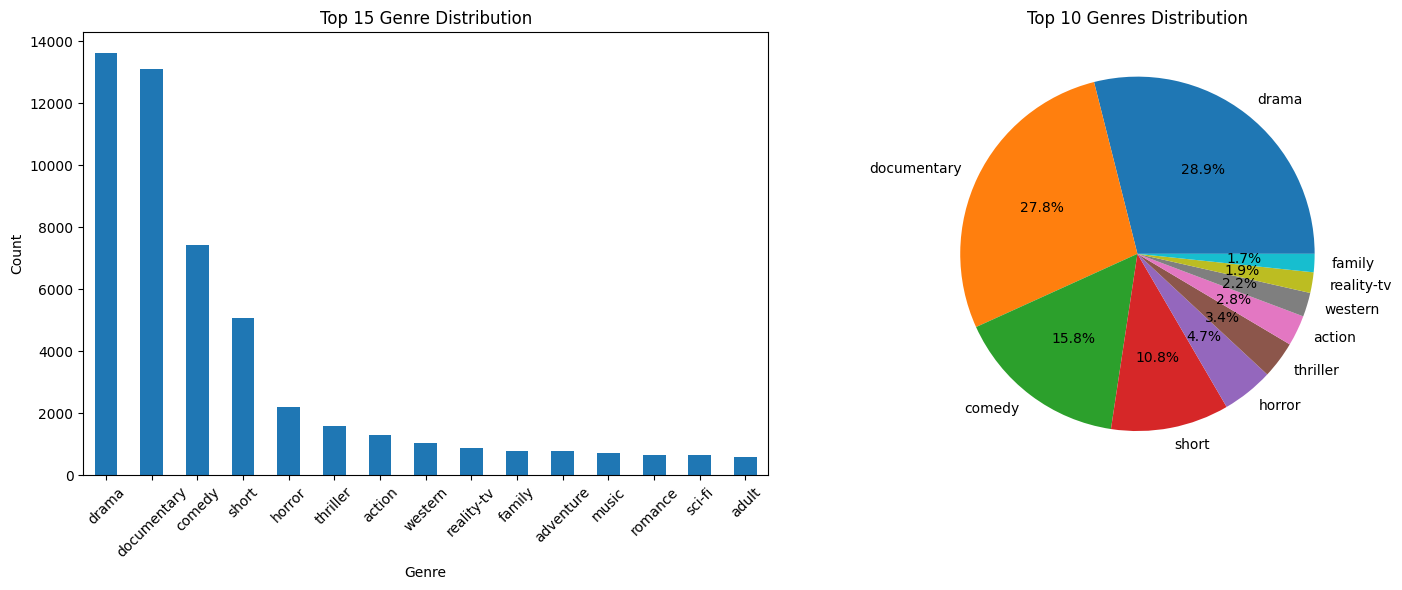


Total number of unique genres: 27


In [3]:
# Explore genre distribution
print("Genre Distribution:")
genre_counts = train_df['Genre'].value_counts()
print(genre_counts.head(15))

# Visualize genre distribution
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
genre_counts.head(15).plot(kind='bar')
plt.title('Top 15 Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(genre_counts.head(10).values, labels=genre_counts.head(10).index, autopct='%1.1f%%')
plt.title('Top 10 Genres Distribution')

plt.tight_layout()
plt.show()

print(f"\nTotal number of unique genres: {train_df['Genre'].nunique()}")

## 3. Data Preprocessing and Cleaning

In [4]:
# Remove rows with missing descriptions
print(f"Original training data shape: {train_df.shape}")
train_df = train_df.dropna(subset=['Description'])
print(f"After removing missing descriptions: {train_df.shape}")

# Remove duplicates
print(f"Duplicates before removal: {train_df.duplicated().sum()}")
train_df = train_df.drop_duplicates(subset=['Description'])
print(f"After removing duplicates: {train_df.shape}")

# Filter to top genres for better model performance (optional - keeps top 10 genres)
top_genres = train_df['Genre'].value_counts().head(10).index.tolist()
train_df_filtered = train_df[train_df['Genre'].isin(top_genres)].copy()

print(f"\nFiltered data shape (top 10 genres): {train_df_filtered.shape}")
print("Genres included:", top_genres)

Original training data shape: (54214, 4)
After removing missing descriptions: (54214, 4)
Duplicates before removal: 0
After removing duplicates: (54086, 4)

Filtered data shape (top 10 genres): (46937, 4)
Genres included: ['drama', 'documentary', 'comedy', 'short', 'horror', 'thriller', 'action', 'western', 'reality-tv', 'adventure']


## 4. Text Preprocessing Functions

In [5]:
def clean_text(text):
    """
    Clean and preprocess text data
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and digits, keep only alphabets and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespaces
    text = ' '.join(text.split())
    
    return text

# Test the function
sample_text = train_df_filtered['Description'].iloc[0]
print("Original text:")
print(sample_text[:200] + "...")
print("\nCleaned text:")
print(clean_text(sample_text)[:200] + "...")

Original text:
Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone...

Cleaned text:
listening in to a conversation between his doctor and parents yearold oscar learns what nobody has the courage to tell him he only has a few weeks to live furious he refuses to speak to anyone except ...


In [6]:
# Apply text cleaning to the dataset
print("Cleaning text data...")
train_df_filtered['cleaned_description'] = train_df_filtered['Description'].apply(clean_text)

# Remove empty descriptions after cleaning
train_df_filtered = train_df_filtered[train_df_filtered['cleaned_description'].str.len() > 0]
print(f"Final dataset shape after cleaning: {train_df_filtered.shape}")

# Display some examples
print("\nExamples of cleaned descriptions:")
for i in range(3):
    print(f"\nGenre: {train_df_filtered.iloc[i]['Genre']}")
    print(f"Cleaned: {train_df_filtered.iloc[i]['cleaned_description'][:150]}...")

Cleaning text data...
Final dataset shape after cleaning: (46937, 5)

Examples of cleaned descriptions:

Genre: drama
Cleaned: listening in to a conversation between his doctor and parents yearold oscar learns what nobody has the courage to tell him he only has a few weeks to ...

Genre: thriller
Cleaned: a brother and sister with a past incestuous relationship have a current murderous relationship he murders the women who reject him and she murders the...

Genre: drama
Cleaned: to help their unemployed father make ends meet edith and her twin sister grace work as seamstresses an invalid grace falls prey to the temptations of ...


## 5. TF-IDF Feature Engineering

In [7]:
# Prepare features and target
X = train_df_filtered['cleaned_description']
y = train_df_filtered['Genre']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target classes: {y.value_counts()}")

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,           # Limit vocabulary size
    ngram_range=(1, 2),          # Use unigrams and bigrams
    stop_words='english',        # Remove English stop words
    max_df=0.95,                 # Ignore terms that appear in >95% of documents
    min_df=2                     # Ignore terms that appear in <2 documents
)

# Fit and transform the text data
print("Applying TF-IDF vectorization...")
X_tfidf = tfidf_vectorizer.fit_transform(X)

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Display some feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Sample features: {feature_names[:20]}")

Features shape: (46937,)
Target shape: (46937,)
Target classes: Genre
drama          13572
documentary    13079
comedy          7429
short           5061
horror          2204
thriller        1590
action          1313
western         1032
reality-tv       882
adventure        775
Name: count, dtype: int64
Applying TF-IDF vectorization...
TF-IDF matrix shape: (46937, 5000)
Vocabulary size: 5000
Sample features: ['aaron' 'abandon' 'abandoned' 'abandons' 'abducted' 'abilities' 'ability'
 'able' 'aboard' 'abortion' 'abroad' 'absence' 'abstract' 'absurd' 'abuse'
 'abused' 'abusive' 'academic' 'academy' 'accept']


## 6. Data Splitting

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain genre distribution in train/test splits
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

# Check genre distribution in splits
print("\nGenre distribution in training set:")
print(y_train.value_counts())
print("\nGenre distribution in test set:")
print(y_test.value_counts())

Training set shape: (37549, 5000)
Test set shape: (9388, 5000)
Training labels shape: (37549,)
Test labels shape: (9388,)

Genre distribution in training set:
Genre
drama          10857
documentary    10463
comedy          5943
short           4049
horror          1763
thriller        1272
action          1050
western          826
reality-tv       706
adventure        620
Name: count, dtype: int64

Genre distribution in test set:
Genre
drama          2715
documentary    2616
comedy         1486
short          1012
horror          441
thriller        318
action          263
western         206
reality-tv      176
adventure       155
Name: count, dtype: int64


## 7. Train Machine Learning Models

### 7.1 Naive Bayes Model

In [9]:
# Initialize and train Naive Bayes model
print("Training Naive Bayes model...")
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train, y_train)

# Make predictions
nb_predictions = nb_model.predict(X_test)

# Calculate accuracy
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

# Get prediction probabilities for confidence scores
nb_probabilities = nb_model.predict_proba(X_test)
print("Naive Bayes model trained successfully!")

Training Naive Bayes model...
Naive Bayes Accuracy: 0.6010
Naive Bayes model trained successfully!


### 7.2 Logistic Regression Model

In [10]:
# Initialize and train Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(
    max_iter=1000,          # Increase iterations for convergence
    random_state=42,
    C=1.0                   # Regularization strength
)
lr_model.fit(X_train, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test)

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# Get prediction probabilities for confidence scores
lr_probabilities = lr_model.predict_proba(X_test)
print("Logistic Regression model trained successfully!")

Training Logistic Regression model...
Logistic Regression Accuracy: 0.6541
Logistic Regression model trained successfully!


### 7.3 Random Forest Model

In [11]:
# Initialize and train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    random_state=42,
    max_depth=20,           # Limit tree depth to prevent overfitting
    min_samples_split=5,    # Minimum samples required to split
    min_samples_leaf=2      # Minimum samples required at leaf node
)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Get prediction probabilities for confidence scores
rf_probabilities = rf_model.predict_proba(X_test)
print("Random Forest model trained successfully!")

Training Random Forest model...
Random Forest Accuracy: 0.5129
Random Forest model trained successfully!


## 8. Model Evaluation and Comparison

In [12]:
# Compare model performances
print("=== MODEL COMPARISON ===")
print(f"Naive Bayes Accuracy:      {nb_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Random Forest Accuracy:    {rf_accuracy:.4f}")

# Store models and their performance
models = {
    'Naive Bayes': {'model': nb_model, 'accuracy': nb_accuracy, 'predictions': nb_predictions},
    'Logistic Regression': {'model': lr_model, 'accuracy': lr_accuracy, 'predictions': lr_predictions},
    'Random Forest': {'model': rf_model, 'accuracy': rf_accuracy, 'predictions': rf_predictions}
}

# Find best model
best_model_name = max(models.keys(), key=lambda x: models[x]['accuracy'])
best_model = models[best_model_name]['model']
print(f"\nBest performing model: {best_model_name}")

# Detailed classification reports
for model_name, model_info in models.items():
    print(f"\n=== {model_name.upper()} CLASSIFICATION REPORT ===")
    print(classification_report(y_test, model_info['predictions']))

=== MODEL COMPARISON ===
Naive Bayes Accuracy:      0.6010
Logistic Regression Accuracy: 0.6541
Random Forest Accuracy:    0.5129

Best performing model: Logistic Regression

=== NAIVE BAYES CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      action       0.72      0.11      0.19       263
   adventure       1.00      0.06      0.11       155
      comedy       0.61      0.44      0.51      1486
 documentary       0.66      0.87      0.75      2616
       drama       0.53      0.82      0.64      2715
      horror       0.76      0.34      0.47       441
  reality-tv       1.00      0.01      0.02       176
       short       0.65      0.13      0.21      1012
    thriller       0.54      0.02      0.04       318
     western       0.96      0.63      0.76       206

    accuracy                           0.60      9388
   macro avg       0.74      0.34      0.37      9388
weighted avg       0.63      0.60      0.55      9388


=== LOGISTIC REGRESSION

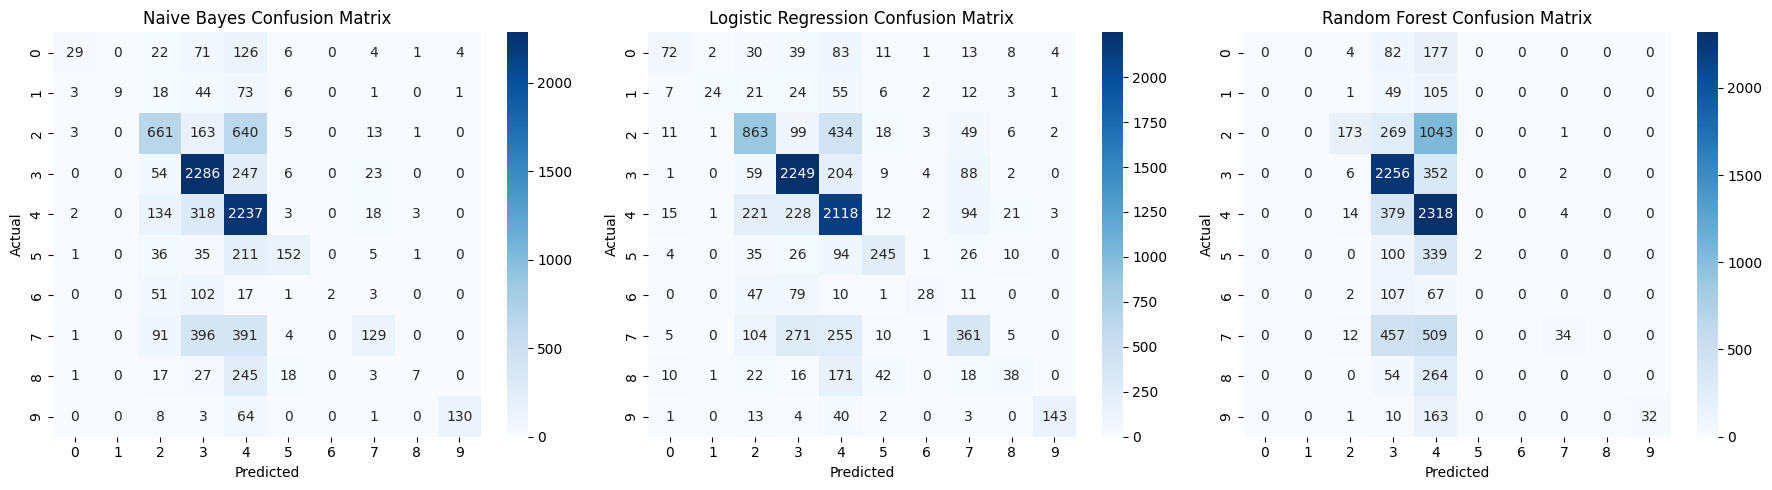

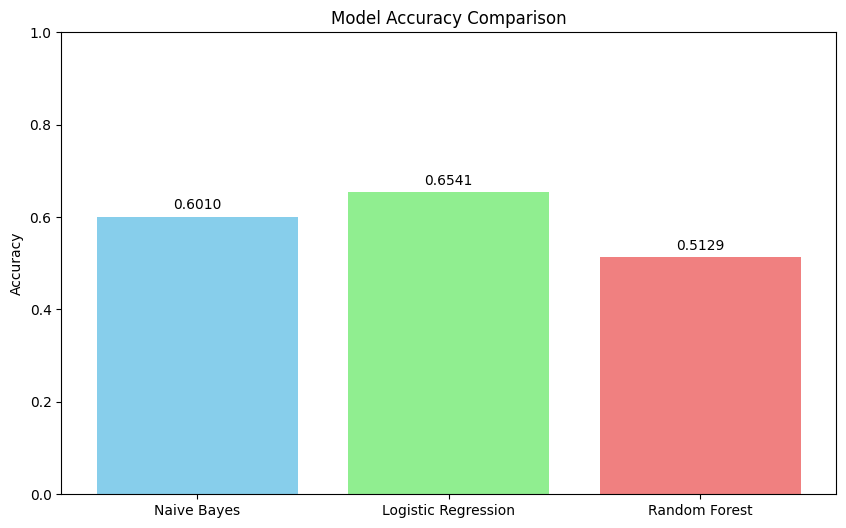

In [13]:
# Visualize confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (model_name, model_info) in enumerate(models.items()):
    cm = confusion_matrix(y_test, model_info['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model_name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Model accuracy comparison chart
model_names = list(models.keys())
accuracies = [models[name]['accuracy'] for name in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add accuracy values on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.4f}', ha='center', va='bottom')

plt.show()

## 9. Genre Prediction Function

In [14]:
def predict_movie_genre(plot_summary, model=None, return_probabilities=True):
    """
    Predict the genre of a movie based on its plot summary
    
    Parameters:
    plot_summary (str): The movie plot summary text
    model: The trained model to use (default: best performing model)
    return_probabilities (bool): Whether to return confidence scores
    
    Returns:
    dict: Contains predicted genre and confidence scores
    """
    if model is None:
        model = best_model
    
    # Clean the input text
    cleaned_text = clean_text(plot_summary)
    
    # Transform text using the fitted TF-IDF vectorizer
    text_tfidf = tfidf_vectorizer.transform([cleaned_text])
    
    # Make prediction
    predicted_genre = model.predict(text_tfidf)[0]
    
    result = {'predicted_genre': predicted_genre}
    
    if return_probabilities:
        # Get prediction probabilities
        probabilities = model.predict_proba(text_tfidf)[0]
        
        # Get class labels
        class_labels = model.classes_
        
        # Create probability dictionary
        prob_dict = dict(zip(class_labels, probabilities))
        
        # Sort by probability (descending)
        sorted_probs = sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)
        
        result['confidence_score'] = prob_dict[predicted_genre]
        result['all_probabilities'] = sorted_probs[:5]  # Top 5 predictions
    
    return result

# Test the function
test_plot = """
A young wizard attends a school of magic and learns about his mysterious past. 
He discovers he is famous in the wizarding world and must face a dark wizard 
who killed his parents when he was a baby.
"""

prediction = predict_movie_genre(test_plot)
print("=== GENRE PREDICTION TEST ===")
print(f"Plot: {test_plot.strip()}")
print(f"Predicted Genre: {prediction['predicted_genre']}")
print(f"Confidence Score: {prediction['confidence_score']:.4f}")
print("Top 5 Predictions:")
for genre, prob in prediction['all_probabilities']:
    print(f"  {genre}: {prob:.4f}")

=== GENRE PREDICTION TEST ===
Plot: A young wizard attends a school of magic and learns about his mysterious past. 
He discovers he is famous in the wizarding world and must face a dark wizard 
who killed his parents when he was a baby.
Predicted Genre: drama
Confidence Score: 0.3676
Top 5 Predictions:
  drama: 0.3676
  thriller: 0.2067
  horror: 0.1834
  action: 0.0796
  short: 0.0669


## 10. Test Predictions with Multiple Examples

In [15]:
# Test with multiple sample plot summaries
test_movies = [
    {
        "title": "Action Movie Example",
        "plot": "A retired special forces operative must save his kidnapped daughter from a group of international terrorists. Armed with special skills and determination, he fights through explosive action sequences and high-speed chases across the city."
    },
    {
        "title": "Horror Movie Example", 
        "plot": "A group of college students spend a weekend at an isolated cabin in the woods. Strange noises in the night lead to terrifying encounters with supernatural forces that threaten their lives."
    },
    {
        "title": "Comedy Movie Example",
        "plot": "Two bumbling friends accidentally become involved in a case of mistaken identity, leading to hilarious misunderstandings and comedic situations as they try to clear their names."
    },
    {
        "title": "Drama Movie Example",
        "plot": "A young woman struggles to overcome personal tragedy while caring for her aging father. Through emotional challenges and family conflicts, she discovers the strength to rebuild her life."
    },
    {
        "title": "Documentary Example",
        "plot": "This film explores the lives of endangered wildlife in their natural habitat, documenting the challenges they face and the conservation efforts being made to protect them."
    }
]

print("=== TESTING GENRE PREDICTION FUNCTION ===\n")

for movie in test_movies:
    print(f"Title: {movie['title']}")
    print(f"Plot: {movie['plot']}")
    
    # Test with all three models
    print("\nPredictions:")
    for model_name, model_info in models.items():
        prediction = predict_movie_genre(movie['plot'], model_info['model'], return_probabilities=False)
        print(f"  {model_name}: {prediction['predicted_genre']}")
    
    # Detailed prediction with best model
    detailed_prediction = predict_movie_genre(movie['plot'])
    print(f"\nBest Model ({best_model_name}) Detailed Results:")
    print(f"  Predicted Genre: {detailed_prediction['predicted_genre']}")
    print(f"  Confidence: {detailed_prediction['confidence_score']:.4f}")
    print("  Top 3 Predictions:")
    for genre, prob in detailed_prediction['all_probabilities'][:3]:
        print(f"    {genre}: {prob:.4f}")
    
    print("-" * 80)

=== TESTING GENRE PREDICTION FUNCTION ===

Title: Action Movie Example
Plot: A retired special forces operative must save his kidnapped daughter from a group of international terrorists. Armed with special skills and determination, he fights through explosive action sequences and high-speed chases across the city.

Predictions:
  Naive Bayes: action
  Logistic Regression: action
  Random Forest: drama

Best Model (Logistic Regression) Detailed Results:
  Predicted Genre: action
  Confidence: 0.9017
  Top 3 Predictions:
    action: 0.9017
    comedy: 0.0216
    drama: 0.0175
--------------------------------------------------------------------------------
Title: Horror Movie Example
Plot: A group of college students spend a weekend at an isolated cabin in the woods. Strange noises in the night lead to terrifying encounters with supernatural forces that threaten their lives.

Predictions:
  Naive Bayes: horror
  Logistic Regression: horror
  Random Forest: drama

Best Model (Logistic Regr

## 11. Summary and Conclusions

### Key Results:
- Successfully trained three different machine learning models for movie genre classification
- Used TF-IDF vectorization to convert text features into numerical representations
- Models achieved varying levels of accuracy on the test dataset
- Created a reusable prediction function that can classify new movie plots

### Model Performance:
The notebook demonstrates how different algorithms perform on text classification tasks, with each having its own strengths and weaknesses for this particular problem.

### Future Improvements:
- Experiment with different TF-IDF parameters (max_features, ngram_range)
- Try advanced text preprocessing (stemming, lemmatization)
- Explore word embeddings (Word2Vec, GloVe) instead of TF-IDF
- Implement cross-validation for more robust model evaluation
- Handle class imbalance with techniques like SMOTE or class weights